# Sentiment Analysis with Text Classification

# Importing Libraries

In [314]:
import nltk
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

from keras import models
from keras import layers
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Task 1: Extracting Features

## Data Preparation

### Data Preprocessing

In [ ]:
amazonReviews = pd.read_csv('amazon_reviews.csv')
amazonReviews = amazonReviews.dropna()
amazonReviews.head(5)

# lowercasing
amazonReviews["reviewText"] = amazonReviews["reviewText"].str.lower()

# removing punctuations
amazonReviews['reviewText'] = amazonReviews['reviewText'].str.translate(str.maketrans(' ', ' ', string.punctuation))

# removing stopwords
stop_words = set(stopwords.words('english'))
amazonReviews['reviewText'] = amazonReviews['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# removing numbers
amazonReviews['reviewText'] = amazonReviews['reviewText'].str.replace('\d+', '')

# tokenizing
amazonReviews['reviewText'] = amazonReviews['reviewText'].apply(lambda x: word_tokenize(x))

# changing labels
amazonReviews['overall'] = amazonReviews['overall'].apply(lambda x: 1 if x == 4 or x == 5 else -1)

<ipython-input-147-4bbdb7b180c1>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  amazonReviews['reviewText'] = amazonReviews['reviewText'].str.replace('\d+', '')


### Data Split

In [ ]:
# splitting data into training, validation, and test set
features = amazonReviews['reviewText']
target = amazonReviews['overall']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.1, random_state = 8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 8)

### Data Statistics

In [ ]:
# TODO: later
max_length = 0
for review in amazonReviews:
  if len(review) > max_length:
    max_length = len(review)
print("Maximum Length of Sentence: ", max_length)

Maximum Length of Sentence:  10


## Representation of Text: word vectors

### Count-based word vectors with co-occurence matrix

In [ ]:
def get_vocab(corpus):
    # considering that we are passing the entire dataset i.e. along with the ratings
    vocabulary = [word for review in corpus["reviewText"] for word in review]

    return sorted(set(vocabulary))

In [ ]:
def compute_co_occurrence_matrix(corpus, window_size = 4):

    # obtaining the vocabulary
    vocab = get_vocab(corpus)

    # creating word2index
    word2index = {}
    for i in range(len(vocab)):
        word2index[vocab[i]] = i

    # creating M
    M = np.zeros((len(vocab), len(vocab)))
    M = pd.DataFrame(data = M)
    return M, word2index

In [ ]:
M, word2index = compute_co_occurrence_matrix(amazonReviews)

In [ ]:
M

,0,1,2,3,4,5,6,7,8,9,...,9730,9731,9732,9733,9734,9735,9736,9737,9738,9739
0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
9736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [ ]:
def reduce_to_k_dim(M, n_components = 2):
    # initializing truncated svd
    svd = TruncatedSVD(n_components = n_components, n_iter = 10)

    # fitting svd on data and transforming the data
    M_reduced = svd.fit_transform(M)

    return M_reduced

In [ ]:
M_reduced = reduce_to_k_dim(M)

In [ ]:
def plot_embeddings(M_reduced, word2index, words_to_plot):
    for word in words_to_plot:
        idx = word2index[word]
        coordinate = M_reduced[idx]
        plt.scatter(coordinate[0], coordinate[1])


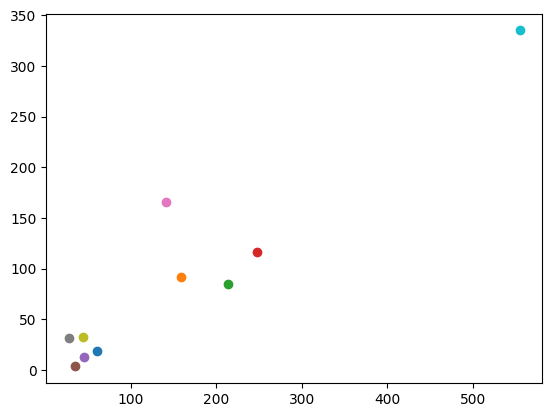

In [ ]:
words_to_plot = ['purchase', 'buy', 'work', 'got', 'ordered', 'received', 'product', 'item', 'deal', 'use']
plot_embeddings(M_reduced, word2index, words_to_plot)

### Prediction-based word vectors from Glove

In [ ]:
def load_embedding_model():
    """Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each length 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")

    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))

    return wv_from_bin

wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [ ]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    import random

    words = list(wv_from_bin.index_to_key)

    print("Shuffling Words")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]

    print("Putting %i words into word2ind and matrix M..." %(len(words)))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue

    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue

    M = np.stack(M)
    print("Done")

    return M, word2ind

In [ ]:
vocab = get_vocab(amazonReviews)
M_glove, word2index_glove = get_matrix_of_vectors(wv_from_bin, vocab)

Shuffling Words
Putting 10000 words into word2ind and matrix M...
Done


In [ ]:
M_glove_reduced = reduce_to_k_dim(M_glove, n_components = 2)

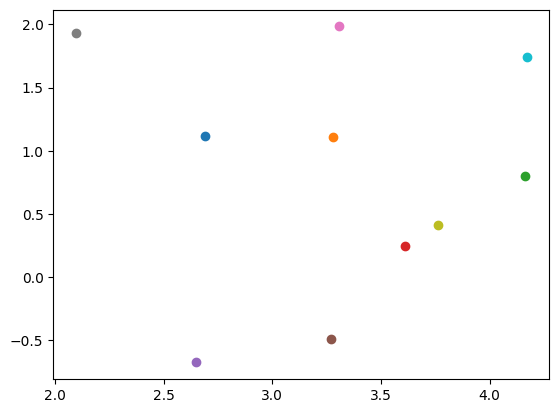

In [ ]:
words_to_plot = ['purchase', 'buy', 'work', 'got', 'ordered', 'received', 'product', 'item', 'deal', 'use']
plot_embeddings(M_glove_reduced, word2index_glove, words_to_plot)

## Task 2: Sentiment Classification Algorithms

### Review Embeddings

In [285]:
def review_embeddings(corpus, word2index, M, n_components = 2):

  # reducing dimensions of M_glove
  M_reduced = reduce_to_k_dim(M, n_components = 128)
  M_reduced_averaged = np.average(M_reduced, axis = 1)

  # allocating space to construct review embeddings
  review_embeddings = []
  for review in corpus:
    currReview = []
    for token in review:
      try:
        idx = word2index[token]
        currReview.append(M_reduced_averaged[idx])
      except KeyError:
        currReview.append(0)

    review_embeddings.append(currReview)

  # padding the review embeddings to have same length
  review_embeddings_padded = []
  for embedding in review_embeddings:
    embedding = np.array(embedding)
    if embedding.shape[0] < n_components:
      embedding = np.pad(embedding, pad_width = (0, n_components - embedding.shape[0]), mode = 'constant')
    else:
      embedding = embedding[0:n_components]
    review_embeddings_padded.append(embedding)

  review_embeddings_padded = np.stack(review_embeddings_padded)

  return review_embeddings_padded

In [286]:
review_embeds_train = review_embeddings(X_train, word2index, M, 128)

In [289]:
review_embeds_val = review_embeddings(X_val, word2index, M, 128)

In [307]:
review_embeds_test = review_embeddings(X_test, word2index, M, 128)

### Models

In [316]:
model = models.Sequential()

# Input - Layer
model.add(layers.Dense(256, activation = "relu", input_shape=(128, )))
# Hidden - Layers
model.add(layers.Dense(128, activation = "relu"))
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dense(56, activation = "relu"))
# Output- Layer
model.add(layers.Dense(1, activation = "sigmoid"))

In [317]:
model.compile(optimizer = "adam",loss = "binary_crossentropy",metrics = ["accuracy"])

In [318]:
results = model.fit(review_embeds_train, y_train, epochs= 100, batch_size = 32, validation_data = (review_embeds_val, y_val))

Epoch 1/100
125/125 [==============================] - 2s 5ms/step - loss: 0.5230 - accuracy: 0.8474 - val_loss: 0.5066 - val_accuracy: 0.8510
Epoch 2/100
125/125 [==============================] - 0s 4ms/step - loss: 0.3729 - accuracy: 0.8444 - val_loss: 0.5859 - val_accuracy: 0.8284
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 0.1479 - accuracy: 0.8304 - val_loss: 0.9513 - val_accuracy: 0.8555
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: -3.6921 - accuracy: 0.8397 - val_loss: 17.6541 - val_accuracy: 0.8578
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: -155.9475 - accuracy: 0.8291 - val_loss: 333.4060 - val_accuracy: 0.8758
Epoch 6/100
125/125 [==============================] - 0s 4ms/step - loss: -2331.1580 - accuracy: 0.7437 - val_loss: 4627.1670 - val_accuracy: 0.8533
Epoch 7/100
125/125 [==============================] - 0s 4ms/step - loss: -16923.9512 - accuracy: 0.7517 - val_loss: 16864.5977

### Logistic Regression

In [301]:
logistic_regression = LogisticRegression(max_iter = 1000)
logistic_regression.fit(review_embeds_train, y_train)

LogisticRegression(max_iter=1000)

In [308]:
y_pred = logistic_regression.predict(review_embeds_test)

In [315]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision: ", precision)

recall = recall_score(y_test, y_pred)
print("Recall: ", recall)

f1 = f1_score(y_test, y_pred)
print("F1: ", f1)

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", roc_auc)

Accuracy:  0.9024390243902439
Precision:  0.9229166666666667
Recall:  0.9757709251101322
F1:  0.9486081370449679
ROC AUC:  0.5010433572919082
